SSL pipeline (Barlow-Twin)

In [2]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psutil

In [3]:
#from keras.layers.merge import add
import matplotlib.pyplot as plt
import os
import scipy

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor
import pickle

In [5]:
#from MOFormer_modded.transformer import Transformer, TransformerRegressor
from MOFormer_modded.dataset_modded import MOF_ID_Dataset
from MOFormer_modded.tokenizer.mof_tokenizer import MOFTokenizer
import csv
import yaml
from MOFormer_modded.model.utils import *

/home/sartaaj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import warnings
from CGCNN.extract import extractFeaturesCGCNN
from CGCNN.extract import collate_pool_mod
from CGCNN.cgcnn_pretrain import CrystalGraphConvNet

In [7]:
tokenizer = MOFTokenizer("MOFormer_modded/tokenizer/vocab_full.txt")
config = yaml.load(open("MOFormer_modded/config_ft_transformer.yaml", "r"), Loader=yaml.FullLoader)
config['dataloader']['randomSeed'] = 0

if torch.cuda.is_available() and config['gpu'] != 'cpu':
    device = config['gpu']
    torch.cuda.set_device(device)
    config['cuda'] = True

else:
    device = 'cpu'
    config['cuda'] = False
print("Running on:", device)

Running on: cuda:0


In [8]:
from MOFormer_modded.transformer import PositionalEncoding
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class Transformer(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.token_encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        # initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        nn.init.xavier_normal_(self.token_encoder.weight)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.token_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, 0:1, :] #this was added in by me

        return output.squeeze(dim = 1) #this was added in by me
        #return output

In [9]:
transformer_SMILES = Transformer(**config['Transformer'])
model = Transformer(**config['Transformer']).to(device)

In [10]:
with open('BW20K/ssl_ds_graph.pickle', 'rb') as handle:
    ssl_ds_graph = pickle.load(handle)

with open('BW20K/ssl_smiles.pickle', 'rb') as handle:
    ssl_smiles = pickle.load(handle)

In [11]:
data_size = len(ssl_smiles) #should give 8.5k entries for CoRE-2019
print(f'Full pretraining set size is {data_size}')
split_ratio = 0.95 #train set %
train_size = int(split_ratio * data_size)

Full pretraining set size is 133


In [12]:
ssl_smiles.shape

(133, 64, 512)

In [13]:
ssl_smiles_train, ssl_graph_train = ssl_smiles[:train_size], ssl_ds_graph[:train_size]
ssl_smiles_val, ssl_graph_val = ssl_smiles[train_size-1::], ssl_ds_graph[train_size-1::]

In [14]:
orig_atom_fea_len, nbr_fea_len = extractFeaturesCGCNN('BW20K/00958972.2016.1253069_1472494_clean.cif').featureLengths()

config_crystal = yaml.load(open("CGCNN/config_ft_cgcnn.yaml", "r"), Loader=yaml.FullLoader) #configurations for CGCNN

config_crystal['model']['orig_atom_fea_len'] = orig_atom_fea_len
config_crystal['model']['nbr_fea_len'] = nbr_fea_len

model_g = CrystalGraphConvNet(**config_crystal['model']).to(device)

1
1
1
1


In [15]:
from SSL.barlow_twins import BarlowTwinsLoss

loss = BarlowTwinsLoss(device = device, batch_size = 64, embed_size = 512, lambd = 0.0051) #same parameters as in moformer

optimizer_g = optim.Adam(model_g.parameters(), lr = 0.00005)
optimizer_t = optim.Adam(model.parameters(), lr = 0.00005)

In [16]:
#now, test for 100 epoch?

num_epoch = 50
loss_history = []
val_history = []
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
norm = False #should embeddings be normalized? in crystal-twin, they don't but for barlow-twin, it's in the algorithm

for epoch in range(num_epoch):
    model_g.train()
    model.train()

    print(f'Epoch : {epoch + 1}')
    loss_ensemble = []
    for bn, (graph, smiles) in enumerate(zip(ssl_graph_train, ssl_smiles_train)):
        input_graph_1 = (Variable(graph[0]).to(device),
                        Variable(graph[1]).to(device),
                        Variable(graph[2]).to(device),
                        [crys_idx.to(device) for crys_idx in graph[3]])
        
        #xrd = torch.tensor(xrd, dtype = torch.float).to(device)
        smiles = torch.from_numpy(smiles).to(device)
        
        z_a = model_g(*input_graph_1) #embedding from cgcnn
        z_b = model(smiles) #embedding from transformer

        if norm == True:
            z_a_norm = (z_a - torch.mean(z_a, axis = 0))/torch.std(z_a, axis = 0)
            z_b_norm = (z_b - torch.mean(z_b, axis = 0))/torch.std(z_b, axis = 0)
        
        else:
            z_a_norm = z_a
            z_b_norm = z_b

        loss_calc = loss(z_a_norm, z_b_norm)
        loss_ensemble.append(loss_calc.item())

        optimizer_g.zero_grad()
        optimizer_t.zero_grad()

        loss_calc.backward()

        optimizer_g.step()
        optimizer_t.step()
    
    torch.cuda.empty_cache()
    val_ensemble = []

    with torch.no_grad():
        model.eval()
        model_g.eval()
        for bn, (graph, smiles) in enumerate(zip(ssl_graph_val, ssl_smiles_val)):
            input_graph_1 = (Variable(graph[0]).to(device),
                            Variable(graph[1]).to(device),
                            Variable(graph[2]).to(device),
                            [crys_idx.to(device) for crys_idx in graph[3]])
            
            #xrd = torch.tensor(xrd, dtype = torch.float).to(device)
            smiles = torch.from_numpy(smiles).to(device)

            z_a = model_g(*input_graph_1)
            z_b = model(smiles)

            if norm == True:
                z_a_norm = (z_a - torch.mean(z_a, axis = 0))/torch.std(z_a, axis = 0)
                z_b_norm = (z_b - torch.mean(z_b, axis = 0))/torch.std(z_b, axis = 0)
            else:
                z_a_norm = z_a
                z_b_norm = z_b
            
            valid_loss = loss(z_a_norm, z_b_norm)
            val_ensemble.append(valid_loss.item())

        val_history.append(np.mean(val_ensemble))
        if np.mean(val_ensemble) < best_valid_loss:
            best_valid_loss = np.mean(val_ensemble)
            
            #save the models here?
            torch.save(model.state_dict(), os.path.join('SSL/pretrained/transformer', f'model_t_{epoch}.pth'))
            torch.save(model_g.state_dict(), os.path.join('SSL/pretrained/cgcnn', f'model_g_{epoch}.pth'))

    
    loss_history.append(np.mean(loss_ensemble))
    print(f'Ensembled Loss : {loss_history[-1]}, Val. Ensembled Loss : {val_history[-1]}')
    print('###############################')

Epoch : 1
Ensembled Loss : 417.2291741749597, Val. Ensembled Loss : 300.11638259887695
###############################
Epoch : 2
Ensembled Loss : 266.1845873878116, Val. Ensembled Loss : 237.77249336242676
###############################
Epoch : 3
Ensembled Loss : 221.06421927800255, Val. Ensembled Loss : 201.29877471923828
###############################
Epoch : 4
Ensembled Loss : 193.00677671886626, Val. Ensembled Loss : 186.0408420562744
###############################
Epoch : 5
Ensembled Loss : 172.15869019523498, Val. Ensembled Loss : 158.97521781921387
###############################
Epoch : 6
Ensembled Loss : 154.2812261430044, Val. Ensembled Loss : 147.70775413513184
###############################
Epoch : 7
Ensembled Loss : 144.60059284028551, Val. Ensembled Loss : 138.9373950958252
###############################
Epoch : 8
Ensembled Loss : 137.14277140299478, Val. Ensembled Loss : 133.8665370941162
###############################
Epoch : 9
Ensembled Loss : 133.01280085245767,

KeyboardInterrupt: 

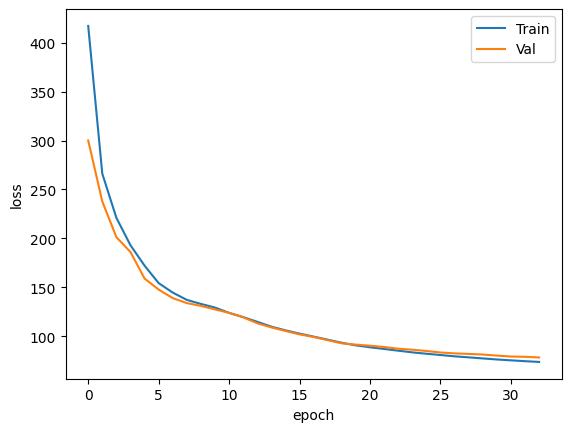

In [17]:
plt.plot(loss_history, label = 'Train')
plt.plot(val_history, label = 'Val')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(loc = 'upper right')

In [ ]:
#not really learning - why? maybe compare to MOFormer and see how much their loss decreased by.
#edit: issue fixed, initially set learning rate -> 0.0051 but it was too high (must have gotten stuck in a local minima somewhere) - it is learning now.